# Momentum Strategy
## PART 1:
- BASELINE
1. SMA(Simple Moving Average)
2. SMA Crossover
3. RSI
4. Strategies based on momentum indicators
5. MACD
## PART 2: Becktest AND Calculate Indicators
## PART 3: TOP 3 Strategies
## PART 4: Problems And Improvement

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go

from pandas_datareader import data as pdr
from IPython.display import display

import datetime as dt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import metrics

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, ward

from statsmodels.tsa.stattools import coint

from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

# PART1
## Download data in the begining

In [5]:
def get_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Log Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data['Log Return'] = data['Log Return'].fillna(0)
    return data

In [6]:
data = get_data("SPY", start_date="2005-11-01", end_date="2024-10-31")

[*********************100%%**********************]  1 of 1 completed


In [7]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Log Return
Date,,,,,,,
2005-11-01,120.580002,120.900002,120.220001,120.489998,83.991104,66365100,0.000000
2005-11-02,120.169998,121.750000,120.129997,121.750000,84.869461,74012300,0.010403
2005-11-03,122.150002,122.660004,121.750000,122.269997,85.231941,84897600,0.004262
2005-11-04,122.400002,122.459999,121.550003,122.110001,85.120430,59156000,-0.001309
2005-11-07,122.370003,122.620003,121.849998,122.230003,85.204056,46765400,0.000982


####  Mark buy and sell signals, and visualize buy and sell signals

In [8]:
def plot_strategy_results_with_baseline(data, baseline_data, strategy_name, 
                                        price_column="Adj Close", 
                                        signal_column="signal_column", 
                                        portfolio_value_column="Portfolio Value", 
                                        baseline_value_column="Portfolio Value"):
    
    if signal_column not in data.columns:
        raise ValueError(f"{signal_column} not found in the data.")
    if portfolio_value_column not in data.columns:
        raise ValueError(f"{portfolio_value_column} not found in the data.")
    if baseline_value_column not in baseline_data.columns:
        raise ValueError(f"{baseline_value_column} not found in the baseline data.")
    
    buy_signals = data[signal_column] == 1
    sell_signals = data[signal_column] == -1

    # buy-sell signal
    plt.figure(figsize=(16, 7))
    plt.plot(data.index, data[price_column], label=f"{price_column} Price", color="blue")
    plt.plot(data.loc[buy_signals].index, data.loc[buy_signals, price_column], "g^", label="BUY", markersize=10)
    plt.plot(data.loc[sell_signals].index, data.loc[sell_signals, price_column], "rv", label="SELL", markersize=10)
    plt.title(f"Buy & Sell Signals for {strategy_name}", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # cumulative return
    plt.figure(figsize=(16, 7))
    plt.plot(data.index, data[portfolio_value_column], label=f"{strategy_name} Portfolio Value", color="orange")
    plt.plot(baseline_data.index, baseline_data[baseline_value_column], label="Baseline Portfolio Value", color="blue", linestyle="-")
    plt.title(f"Cumulative Returns: {strategy_name} vs Baseline", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Portfolio Value", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


## Baseline(Market Line)
> Buy signal: Buy all positions on the initial date\
> Sell signal: Sell all on the final date

In [9]:
def baseline_strategy(data, initial_capital=100000):
    data['Position'] = 1
    # cumulative Log Return
    data['Cumulative Log Return'] = data['Log Return'].cumsum()
    # convert to the Portfolio Value
    data['Baseline Portfolio Value'] = np.exp(data['Cumulative Log Return']) * initial_capital
    return data

In [10]:
data_baseline = baseline_strategy(data)
print(f"Initial Portfolio Value (baseline): ${data['Baseline Portfolio Value'].iloc[1]:,.2f}")
print(f"Final Portfolio Value (baseline): ${data['Baseline Portfolio Value'].iloc[-1]:,.2f}")

Initial Portfolio Value (baseline): $101,045.77
Final Portfolio Value (baseline): $690,561.24


## 1.1 SMA:
> SPOT PRICE > MOVING AVERAGE LINE， upward trend， BUY\
> SPOT PRICE < MOVING AVERAGE LINE， downward trend， SELL\
> Simple and direct, LESS calculation\
> Suitable for markets with clear trends\
> more sensitive to short-term noise and may appear as false signals

In [11]:
def sma_strategy(data, short_window, long_window, initial_capital=100000):
    data['SMA_short'] = data['Adj Close'].rolling(window=short_window).mean()
    data['SMA_long'] = data['Adj Close'].rolling(window=long_window).mean()
    
    # 生成信号：短期均线 > 长期均线，则仓位为1；否则为-1
    data['SMA_signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, -1)
    
    # adjusted the log return by the signal
    data['SMA Strategy Log Return'] = data['SMA_signal'].shift(1) * data['Log Return']
    
    # Cumulative Log Return
    data['SMA Cumulative Log Return'] = data['SMA Strategy Log Return'].cumsum()
    
    # CONVERT TO THE portfolio value
    data['SMA Portfolio Value'] = np.exp(data['SMA Cumulative Log Return']) * initial_capital
    data['SMA Portfolio Value'].iloc[0] = initial_capital
    # moving the NAN
    data = data.dropna()
    
    return data

In [12]:
data_sma = sma_strategy(data, short_window=20, long_window=50)

In [13]:
print(f"Initial Portfolio Value (SMA): ${data['SMA Portfolio Value'].iloc[1]:,.2f}")
print(f"Final Portfolio Value (SMA): ${data['SMA Portfolio Value'].iloc[-1]:,.2f}")

Initial Portfolio Value (SMA): $98,965.05
Final Portfolio Value (SMA): $100,610.44


Training Data Initial Portfolio Value (SMA): $93,054.83
Training Data Final Portfolio Value (SMA): $126,466.15
Testing Data Initial Portfolio Value (SMA): $97,422.97
Testing Data Final Portfolio Value (SMA): $75,491.79


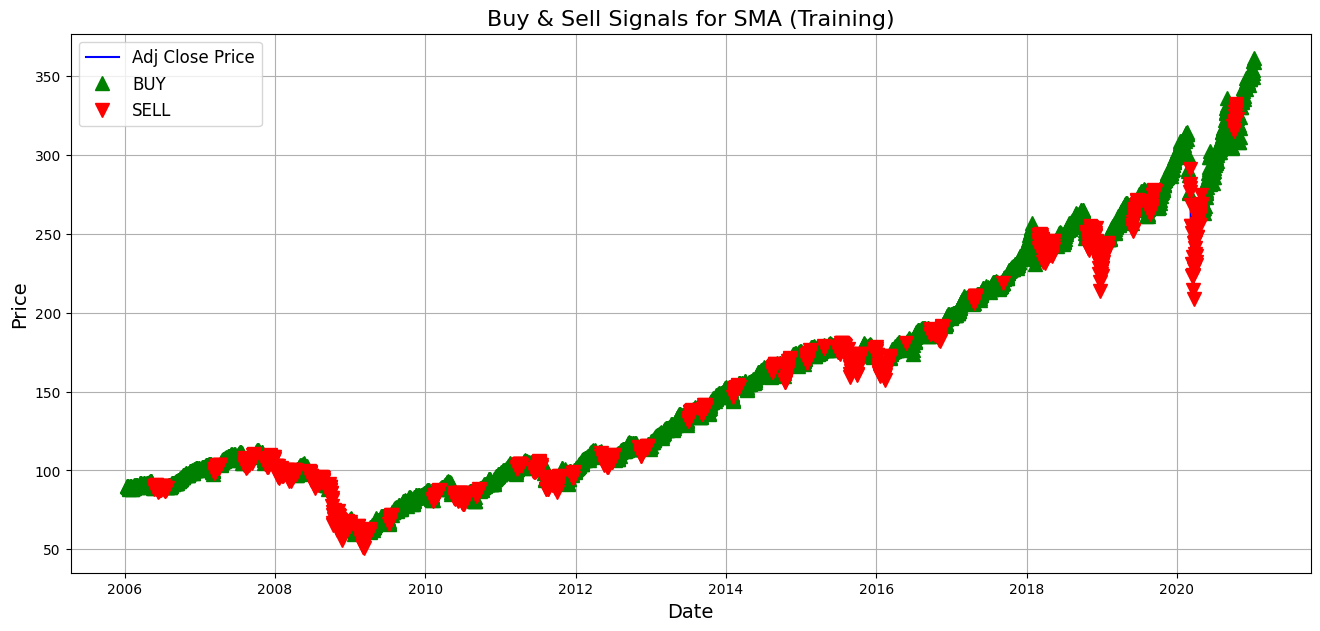

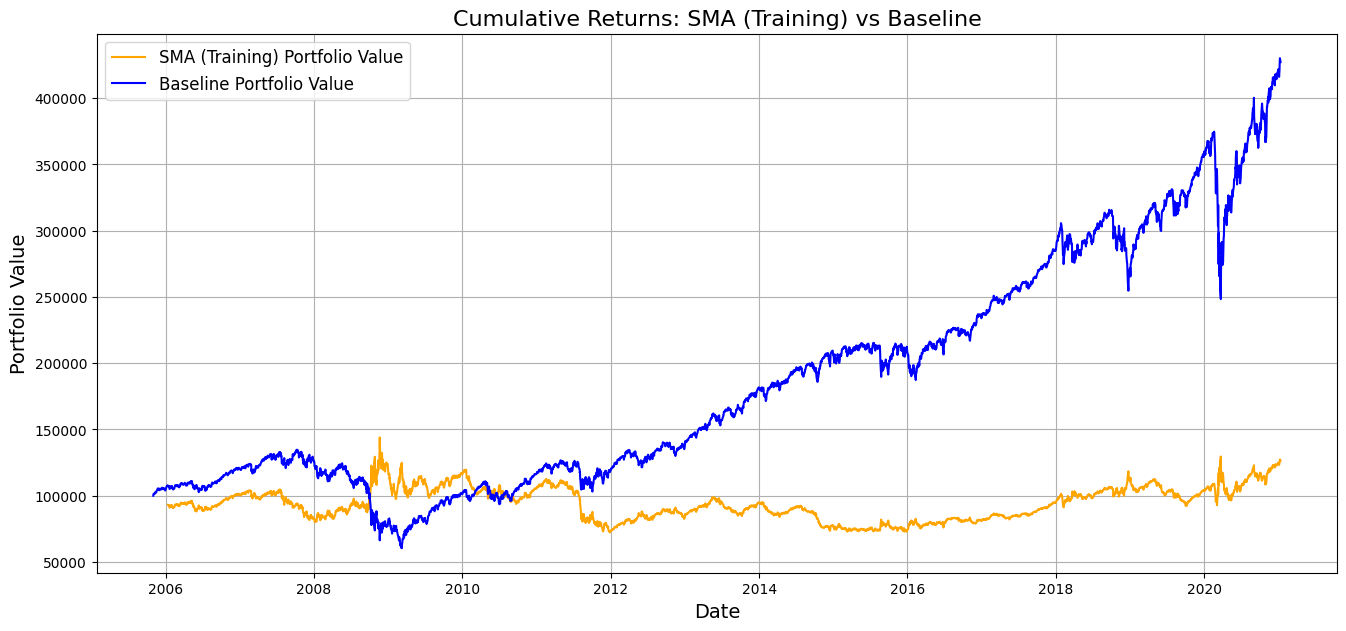

In [26]:
# 分割数据：80% 为训练集，20% 为测试集
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# 在训练集上运行 SMA 策略
data_train_sma = sma_strategy(train_data, short_window=20, long_window=50)

# 在测试集上运行 SMA 策略
data_test_sma = sma_strategy(test_data, short_window=20, long_window=50)

# 打印训练集和测试集的初始与最终组合价值
print(f"Training Data Initial Portfolio Value (SMA): ${data_train_sma['SMA Portfolio Value'].iloc[0]:,.2f}")
print(f"Training Data Final Portfolio Value (SMA): ${data_train_sma['SMA Portfolio Value'].iloc[-1]:,.2f}")

print(f"Testing Data Initial Portfolio Value (SMA): ${data_test_sma['SMA Portfolio Value'].iloc[0]:,.2f}")
print(f"Testing Data Final Portfolio Value (SMA): ${data_test_sma['SMA Portfolio Value'].iloc[-1]:,.2f}")

# 绘制训练集结果
plot_strategy_results_with_baseline(
    data=data_train_sma,
    baseline_data=data_baseline.loc[train_data.index],  # 匹配训练集时间范围
    strategy_name="SMA (Training)",
    price_column="Adj Close",
    signal_column="SMA_signal",
    portfolio_value_column="SMA Portfolio Value",
    baseline_value_column="Baseline Portfolio Value"
)


## 1.2 SMA Crossover
> Using moving averages in two different time Windows(short-term:recent trend, long-term:secular trend).\
> When the short-term moving average crosses the long-term moving average upward, buy.\
> When the short-term moving average crosses the long-term moving average downward,sell.\
> Paying more attention to trend changes can effectively reduce false signals of short-term volatility.\
> It follows the long-term trend well, but the signal response speed is slow.

In [28]:
# SMA Crossover 策略
def sma_crossover_strategy(data, short_window, long_window, initial_capital=100000):
    """
    SMA Crossover策略。
    """
    # 计算短期和长期均线
    data['SMA_short'] = data['Adj Close'].rolling(window=short_window).mean()
    data['SMA_long'] = data['Adj Close'].rolling(window=long_window).mean()

    # 生成买卖信号
    data['SMA_signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, -1)

    # 使用信号调整对数收益
    data['SMA Strategy Log Return'] = data['SMA_signal'].shift(1) * data['Log Return']

    # 计算累计对数收益并转换为组合价值
    data['SMA Cumulative Log Return'] = data['SMA Strategy Log Return'].cumsum()
    data['SMA Portfolio Value'] = np.exp(data['SMA Cumulative Log Return']) * initial_capital

    # 移除无效数据
    return data.dropna()

# 调用 SMA Crossover 策略
data_sma_crossover = sma_crossover_strategy(data, short_window=50, long_window=200, initial_capital=100000)

# 打印初始和最终组合价值
print(f"Initial Portfolio Value (SMA Crossover): ${data_sma_crossover['SMA Portfolio Value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value (SMA Crossover): ${data_sma_crossover['SMA Portfolio Value'].iloc[-1]:,.2f}")


Initial Portfolio Value (SMA Crossover): $91,405.48
Final Portfolio Value (SMA Crossover): $404,775.12


Training Data Initial Portfolio Value (SMA Crossover): $91,405.48
Training Data Final Portfolio Value (SMA Crossover): $223,270.51
Testing Data Initial Portfolio Value (SMA Crossover): $82,266.13
Testing Data Final Portfolio Value (SMA Crossover): $122,668.44


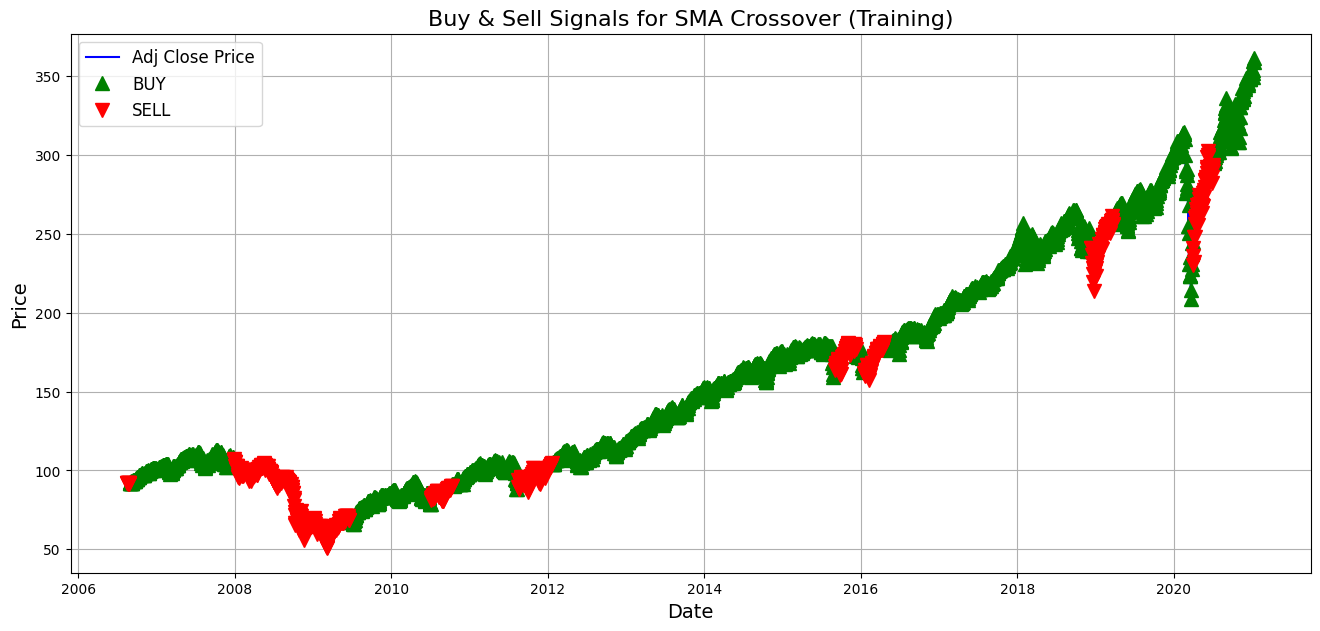

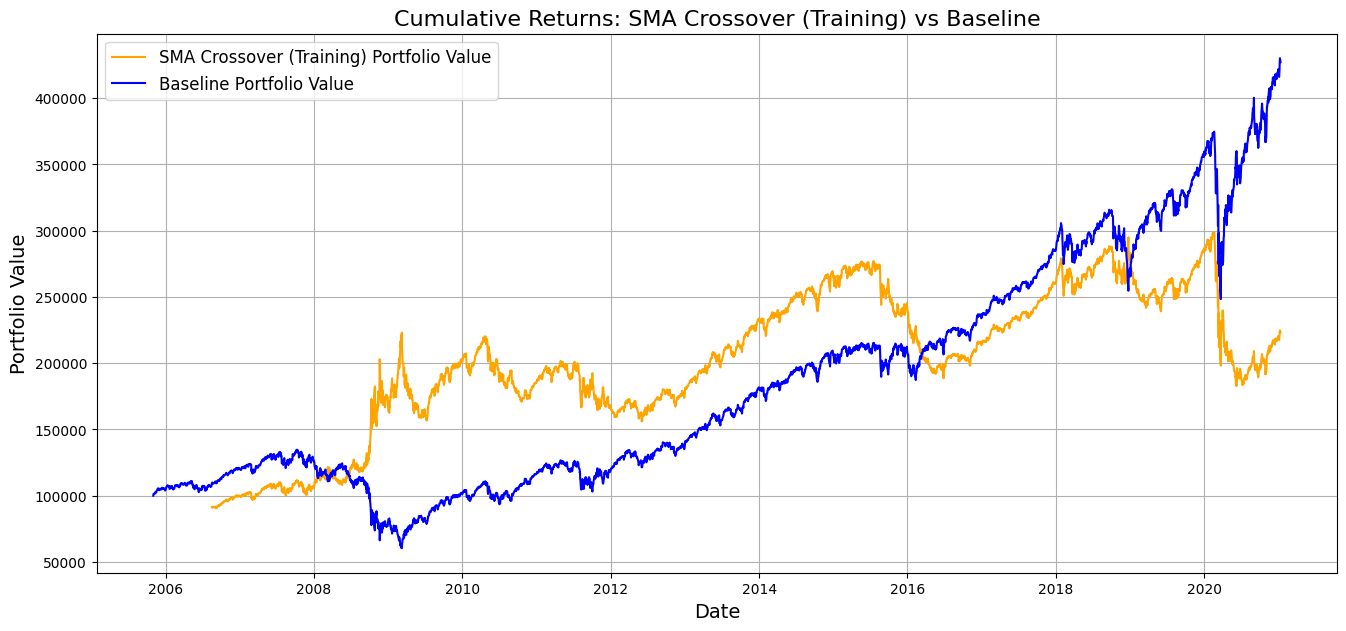

In [29]:
# 分割数据：80% 为训练集，20% 为测试集
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# 在训练集上运行 SMA Crossover 策略
data_train_sma_crossover = sma_crossover_strategy(train_data, short_window=50, long_window=200, initial_capital=100000)

# 在测试集上运行 SMA Crossover 策略
data_test_sma_crossover = sma_crossover_strategy(test_data, short_window=50, long_window=200, initial_capital=100000)

# 打印训练集和测试集的初始与最终组合价值
print(f"Training Data Initial Portfolio Value (SMA Crossover): ${data_train_sma_crossover['SMA Portfolio Value'].iloc[0]:,.2f}")
print(f"Training Data Final Portfolio Value (SMA Crossover): ${data_train_sma_crossover['SMA Portfolio Value'].iloc[-1]:,.2f}")

print(f"Testing Data Initial Portfolio Value (SMA Crossover): ${data_test_sma_crossover['SMA Portfolio Value'].iloc[0]:,.2f}")
print(f"Testing Data Final Portfolio Value (SMA Crossover): ${data_test_sma_crossover['SMA Portfolio Value'].iloc[-1]:,.2f}")

# 绘制训练集结果
plot_strategy_results_with_baseline(
    data=data_train_sma_crossover,
    baseline_data=data_baseline.loc[train_data.index],  # 匹配训练集时间范围
    strategy_name="SMA Crossover (Training)",
    price_column="Adj Close",
    signal_column="SMA_signal",
    portfolio_value_column="SMA Portfolio Value",
    baseline_value_column="Baseline Portfolio Value"
)



## 1.3 RSI
> Buy when RSI is less than 30 (oversold)\
> sell when RSI is greater than 70 (overbought)

In [30]:
def rsi_strategy(data, overbought=70, oversold=30, initial_capital=100000):
    
    # 计算价格变动
    delta = data['Adj Close'].diff()

    # 计算上涨和下跌
    gain = np.where(delta > 0, delta, 0)  # 上涨部分
    loss = np.where(delta < 0, -delta, 0)  # 下跌部分

    # 计算平均上涨和下跌
    avg_gain = pd.Series(gain, index=data.index).rolling(window=14).mean()
    avg_loss = pd.Series(loss, index=data.index).rolling(window=14).mean()

    # 计算RS（Relative Strength）
    rs = avg_gain / avg_loss

    # 计算RSI
    data['RSI'] = 100 - (100 / (1 + rs))

    # 根据RSI生成交易信号：RSI > overbought，卖出(-1)；RSI < oversold，买入(+1)
    data['RSI_signal'] = np.where(data['RSI'] > overbought, -1, np.where(data['RSI'] < oversold, 1, 0))

    # 使用信号调整对数收益
    data['RSI Strategy Log Return'] = data['RSI_signal'].shift(1) * data['Log Return']

    # 累计对数收益
    data['RSI Cumulative Log Return'] = data['RSI Strategy Log Return'].cumsum()

    # 转化为组合价值（基于初始资金）
    data['RSI Portfolio Value'] = np.exp(data['RSI Cumulative Log Return']) * initial_capital

    # 移除无效数据（由于rolling和shift带来的NaN）
    return data.dropna()


# 调用 RSI 策略
data_rsi = rsi_strategy(data, overbought=70, oversold=30, initial_capital=100000)

# 打印初始和最终组合价值
print(f"Initial Portfolio Value (RSI Strategy): ${data_rsi['RSI Portfolio Value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value (RSI Strategy): ${data_rsi['RSI Portfolio Value'].iloc[-1]:,.2f}")


Initial Portfolio Value (RSI Strategy): $104,563.99
Final Portfolio Value (RSI Strategy): $242,378.27


Training Data Initial Portfolio Value (RSI): $104,563.99
Training Data Final Portfolio Value (RSI): $193,723.67
Testing Data Initial Portfolio Value (RSI): $100,000.00
Testing Data Final Portfolio Value (RSI): $121,440.29


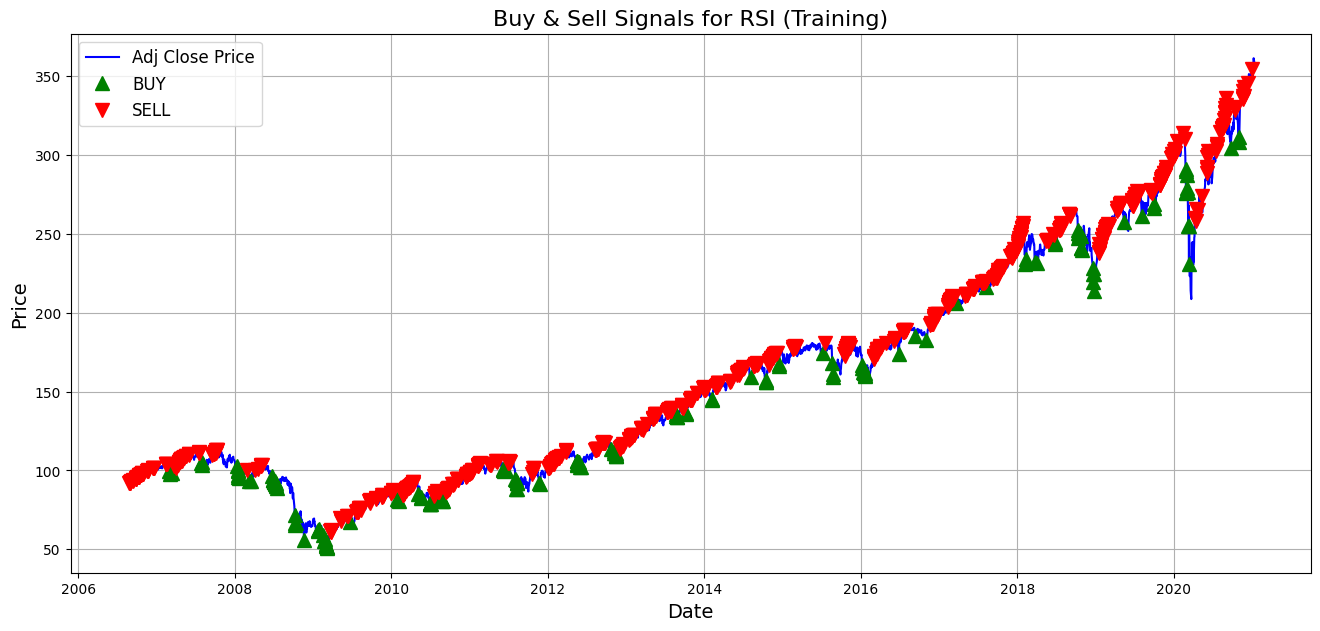

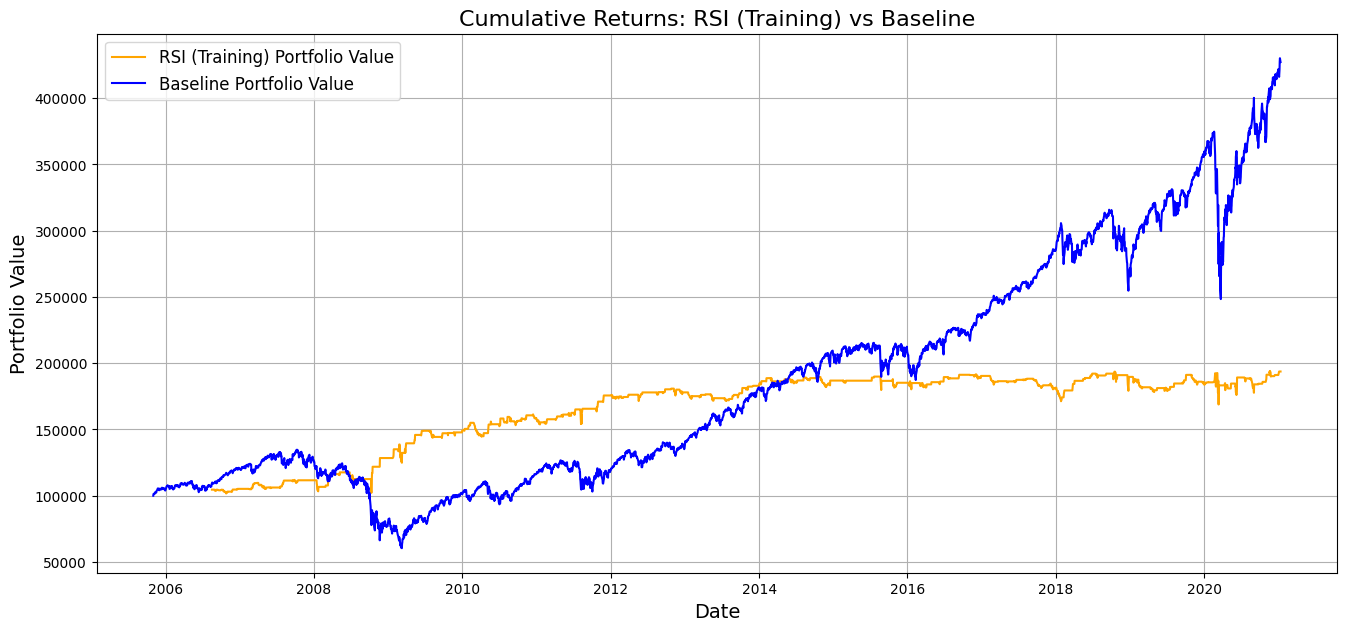

In [31]:
# 分割数据：80% 为训练集，20% 为测试集
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# 在训练集上运行 RSI 策略
data_train_rsi = rsi_strategy(train_data, overbought=70, oversold=30, initial_capital=100000)

# 在测试集上运行 RSI 策略
data_test_rsi = rsi_strategy(test_data, overbought=70, oversold=30, initial_capital=100000)

# 打印训练集和测试集的初始与最终组合价值
print(f"Training Data Initial Portfolio Value (RSI): ${data_train_rsi['RSI Portfolio Value'].iloc[0]:,.2f}")
print(f"Training Data Final Portfolio Value (RSI): ${data_train_rsi['RSI Portfolio Value'].iloc[-1]:,.2f}")

print(f"Testing Data Initial Portfolio Value (RSI): ${data_test_rsi['RSI Portfolio Value'].iloc[0]:,.2f}")
print(f"Testing Data Final Portfolio Value (RSI): ${data_test_rsi['RSI Portfolio Value'].iloc[-1]:,.2f}")

# 绘制训练集结果
plot_strategy_results_with_baseline(
    data=data_train_rsi,
    baseline_data=data_baseline.loc[train_data.index],  # 匹配训练集时间范围
    strategy_name="RSI (Training)",
    price_column="Adj Close",
    signal_column="RSI_signal",
    portfolio_value_column="RSI Portfolio Value",
    baseline_value_column="Baseline Portfolio Value"
)


## 1.4 Strategies based on momentum indicators
> Calculate the rate of price change (momentum) for a specific window period, buying when momentum is greater than the threshold and selling when momentum is less than the threshold

In [32]:
def momentum_strategy(data, window=14, initial_capital=100000):
    
    # 计算动量：当前价格减去窗口期之前的价格
    data['Momentum'] = data['Adj Close'] - data['Adj Close'].shift(window)
    
    # 根据动量生成信号：正动量买入(+1)，负动量卖出(-1)
    data['Momentum_signal'] = np.where(data['Momentum'] > 0, 1, -1)
    
    # 策略对数收益 = 仓位信号（滞后一天）× 对数收益
    data['Momentum Strategy Log Return'] = data['Momentum_signal'].shift(1) * data['Log Return']
    
    # 累计对数收益
    data['Momentum Cumulative Log Return'] = data['Momentum Strategy Log Return'].cumsum()
    
    # 转化为组合价值
    data['Momentum Portfolio Value'] = np.exp(data['Momentum Cumulative Log Return']) * initial_capital
    
    # 移除无效数据（由于rolling和shift带来的NaN）
    return data.dropna()


# apply Momentum strategy
data_momentum = momentum_strategy(data, window=14, initial_capital=100000)

# 打印初始和最终组合价值
print(f"Initial Portfolio Value (Momentum Strategy): ${data_momentum['Momentum Portfolio Value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value (Momentum Strategy): ${data_momentum['Momentum Portfolio Value'].iloc[-1]:,.2f}")


Initial Portfolio Value (Momentum Strategy): $91,078.86
Final Portfolio Value (Momentum Strategy): $165,166.27


Training Data Initial Portfolio Value (Momentum): $91,078.86
Training Data Final Portfolio Value (Momentum): $141,428.50
Testing Data Initial Portfolio Value (Momentum): $99,271.40
Testing Data Final Portfolio Value (Momentum): $117,465.64


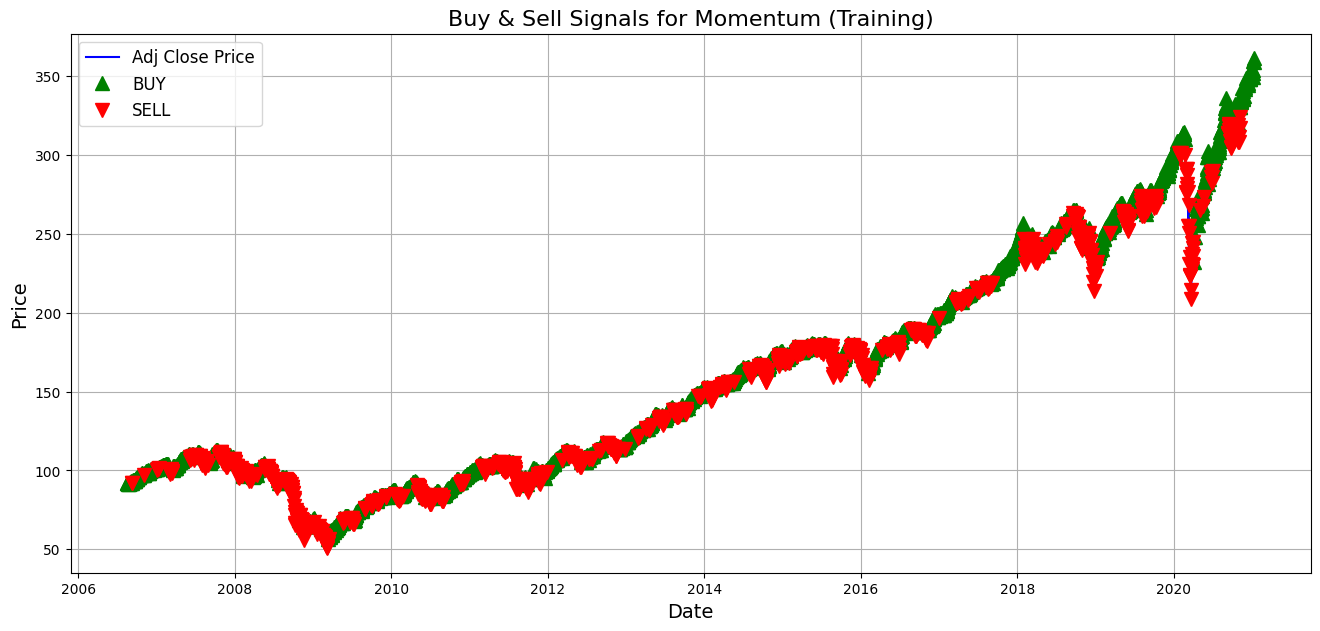

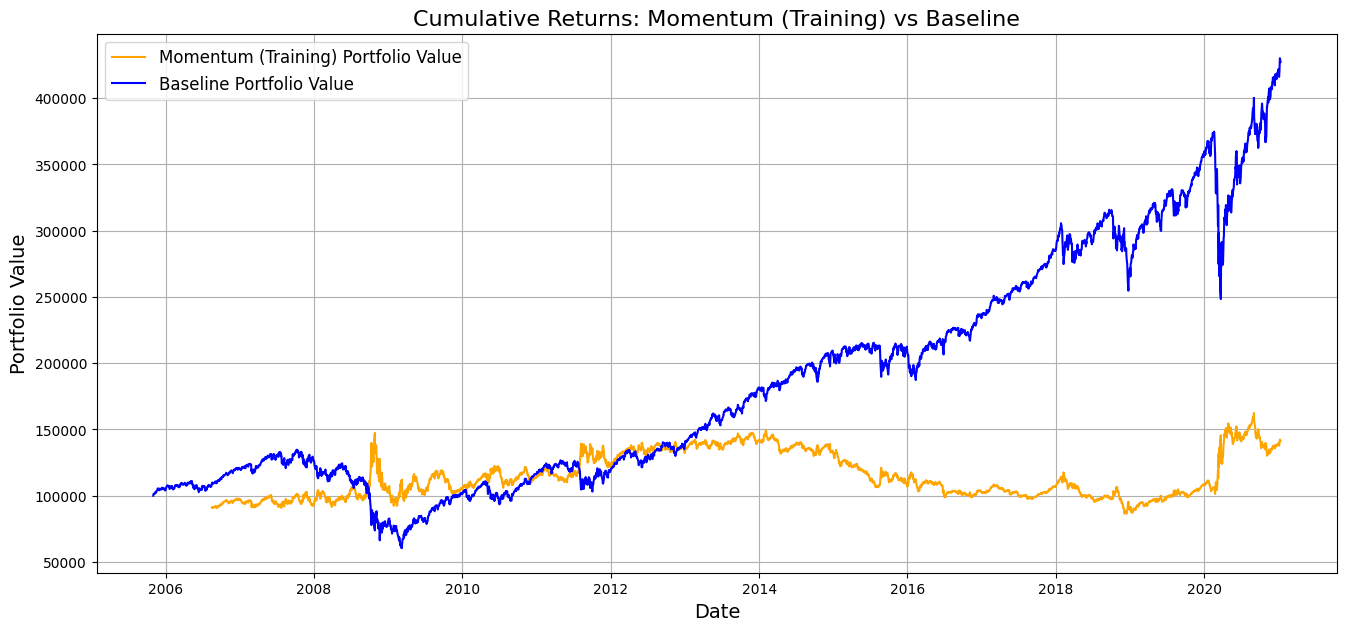

In [33]:
# 分割数据：80% 为训练集，20% 为测试集
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# 在训练集上运行 Momentum 策略
data_train_momentum = momentum_strategy(train_data, window=14, initial_capital=100000)

# 在测试集上运行 Momentum 策略
data_test_momentum = momentum_strategy(test_data, window=14, initial_capital=100000)

# 打印训练集和测试集的初始与最终组合价值
print(f"Training Data Initial Portfolio Value (Momentum): ${data_train_momentum['Momentum Portfolio Value'].iloc[0]:,.2f}")
print(f"Training Data Final Portfolio Value (Momentum): ${data_train_momentum['Momentum Portfolio Value'].iloc[-1]:,.2f}")

print(f"Testing Data Initial Portfolio Value (Momentum): ${data_test_momentum['Momentum Portfolio Value'].iloc[0]:,.2f}")
print(f"Testing Data Final Portfolio Value (Momentum): ${data_test_momentum['Momentum Portfolio Value'].iloc[-1]:,.2f}")

# 绘制训练集结果
plot_strategy_results_with_baseline(
    data=data_train_momentum,
    baseline_data=data_baseline.loc[train_data.index],  # 匹配训练集时间范围
    strategy_name="Momentum (Training)",
    price_column="Adj Close",
    signal_column="Momentum_signal",
    portfolio_value_column="Momentum Portfolio Value",
    baseline_value_column="Baseline Portfolio Value"
)

## 1.5 MACD
> The difference between the short-term exponential moving average (EMA) and the long-term exponential moving average.\
> The signal line is a smooth moving average of MACD.\
> Buy when MACD crosses the signal line above and sell when MACD crosses the signal line below.

In [34]:
def macd_strategy(data, short_span=12, long_span=26, signal_span=9, initial_capital=100000):
    
    # short-term and long-term EMA
    data['EMA_short'] = data['Adj Close'].ewm(span=short_span, adjust=False).mean()
    data['EMA_long'] = data['Adj Close'].ewm(span=long_span, adjust=False).mean()
    
    # calculate MACD and signal line
    data['MACD'] = data['EMA_short'] - data['EMA_long']
    data['Signal Line'] = data['MACD'].ewm(span=signal_span, adjust=False).mean()
    
    data['MACD_signal'] = np.where(data['MACD'] > data['Signal Line'], 1, -1)
    
    data['MACD Strategy Log Return'] = data['MACD_signal'].shift(1) * data['Log Return']
    
    # cumulative log return
    data['MACD Cumulative Log Return'] = data['MACD Strategy Log Return'].cumsum()
    
    # convert to the portfolio value
    data['MACD Portfolio Value'] = np.exp(data['MACD Cumulative Log Return']) * initial_capital
    
    # remove nan
    return data.dropna()


# apply MACD
data_macd = macd_strategy(data, short_span=12, long_span=26, signal_span=9, initial_capital=100000)

print(f"Initial Portfolio Value (MACD Strategy): ${data_macd['MACD Portfolio Value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value (MACD Strategy): ${data_macd['MACD Portfolio Value'].iloc[-1]:,.2f}")


Initial Portfolio Value (MACD Strategy): $88,629.88
Final Portfolio Value (MACD Strategy): $124,434.70


Training Data Initial Portfolio Value (MACD): $88,629.88
Training Data Final Portfolio Value (MACD): $131,787.15
Testing Data Initial Portfolio Value (MACD): $99,731.42
Testing Data Final Portfolio Value (MACD): $94,865.18


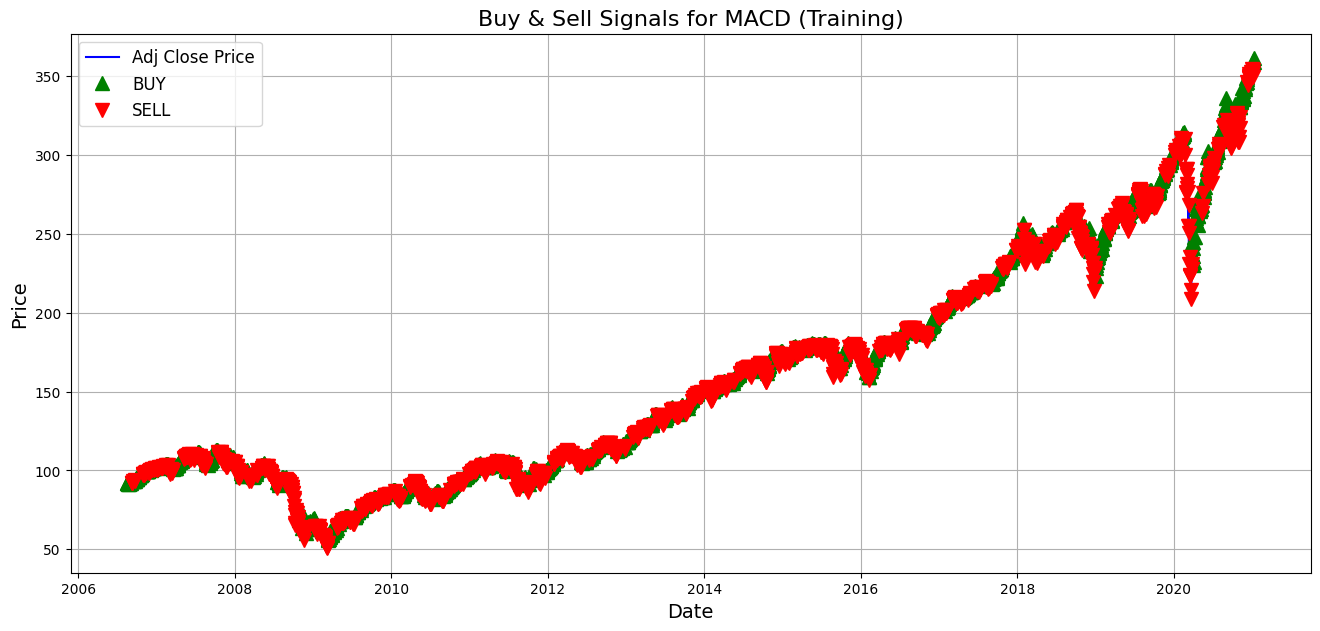

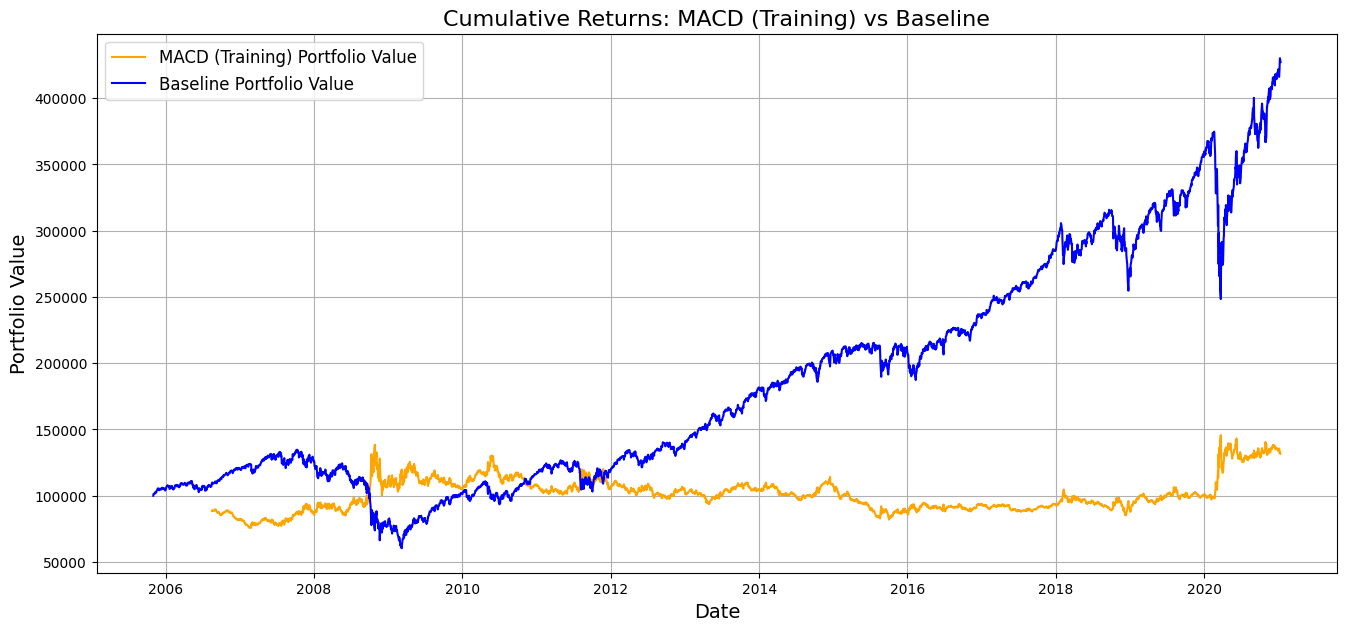

In [35]:
# 分割数据：80% 为训练集，20% 为测试集
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# 在训练集上运行 MACD 策略
data_train_macd = macd_strategy(train_data, short_span=12, long_span=26, signal_span=9, initial_capital=100000)

# 在测试集上运行 MACD 策略
data_test_macd = macd_strategy(test_data, short_span=12, long_span=26, signal_span=9, initial_capital=100000)

# 打印训练集和测试集的初始与最终组合价值
print(f"Training Data Initial Portfolio Value (MACD): ${data_train_macd['MACD Portfolio Value'].iloc[0]:,.2f}")
print(f"Training Data Final Portfolio Value (MACD): ${data_train_macd['MACD Portfolio Value'].iloc[-1]:,.2f}")

print(f"Testing Data Initial Portfolio Value (MACD): ${data_test_macd['MACD Portfolio Value'].iloc[0]:,.2f}")
print(f"Testing Data Final Portfolio Value (MACD): ${data_test_macd['MACD Portfolio Value'].iloc[-1]:,.2f}")

# 绘制训练集结果
plot_strategy_results_with_baseline(
    data=data_train_macd,
    baseline_data=data_baseline.loc[train_data.index],  # 匹配训练集时间范围
    strategy_name="MACD (Training)",
    price_column="Adj Close",
    signal_column="MACD_signal",
    portfolio_value_column="MACD Portfolio Value",
    baseline_value_column="Baseline Portfolio Value"
)


# Part2 Becktest AND Calculate Indicators

In [41]:
def calculate_metrics(data, portfolio_column):
    """
    Calculate Sharpe Ratio, CAGR, Max Drawdown, and Final Portfolio Value.

    Parameters:
    - data: DataFrame containing the portfolio value column.
    - portfolio_column: The name of the column containing portfolio values.

    Returns:
    - A dictionary with Sharpe Ratio, CAGR, Max Drawdown, and Final Portfolio Value.
    """
    # Calculate daily returns
    data["Daily Return"] = data[portfolio_column].pct_change()
    
    # Sharpe Ratio
    sharpe_ratio = data["Daily Return"].mean() / data["Daily Return"].std() * np.sqrt(252)  # 252 trading days
    
    # CAGR (Compound Annual Growth Rate)
    start_value = data[portfolio_column].iloc[0]
    end_value = data[portfolio_column].iloc[-1]
    total_years = (data.index[-1] - data.index[0]).days / 365.25
    cagr = (end_value / start_value) ** (1 / total_years) - 1
    
    # Maximum Drawdown
    rolling_max = data[portfolio_column].cummax()
    drawdown = data[portfolio_column] / rolling_max - 1
    max_drawdown = drawdown.min()
    
    # Final Portfolio Value
    final_portfolio_value = data[portfolio_column].iloc[-1]
    
    return sharpe_ratio, cagr, max_drawdown, final_portfolio_value


               Sharpe Ratio      CAGR  Max Drawdown  Final Portfolio Value
Strategy                                                                  
Baseline           0.623346  0.107082     -0.551894          690561.239552
SMA                0.118667  0.004162     -0.497932          100610.441543
SMA Crossover      0.515369  0.085176     -0.388891          404775.123297
RSI                0.524454  0.047265     -0.131571          242378.269591
Momentum           0.264354  0.033238     -0.420933          165166.271607
MACD               0.193011  0.018814     -0.408395          124434.703730


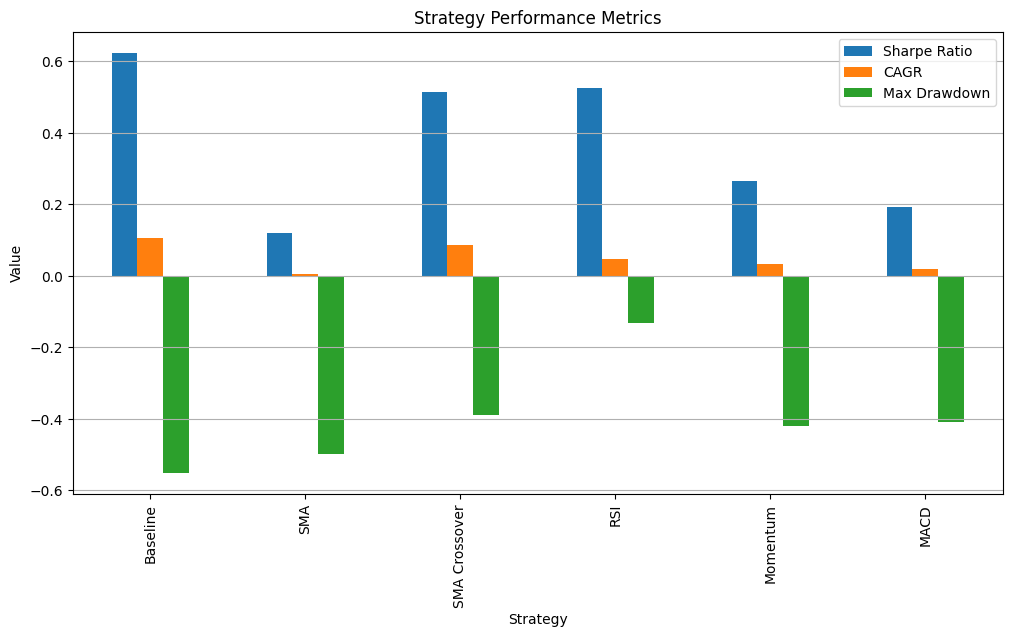

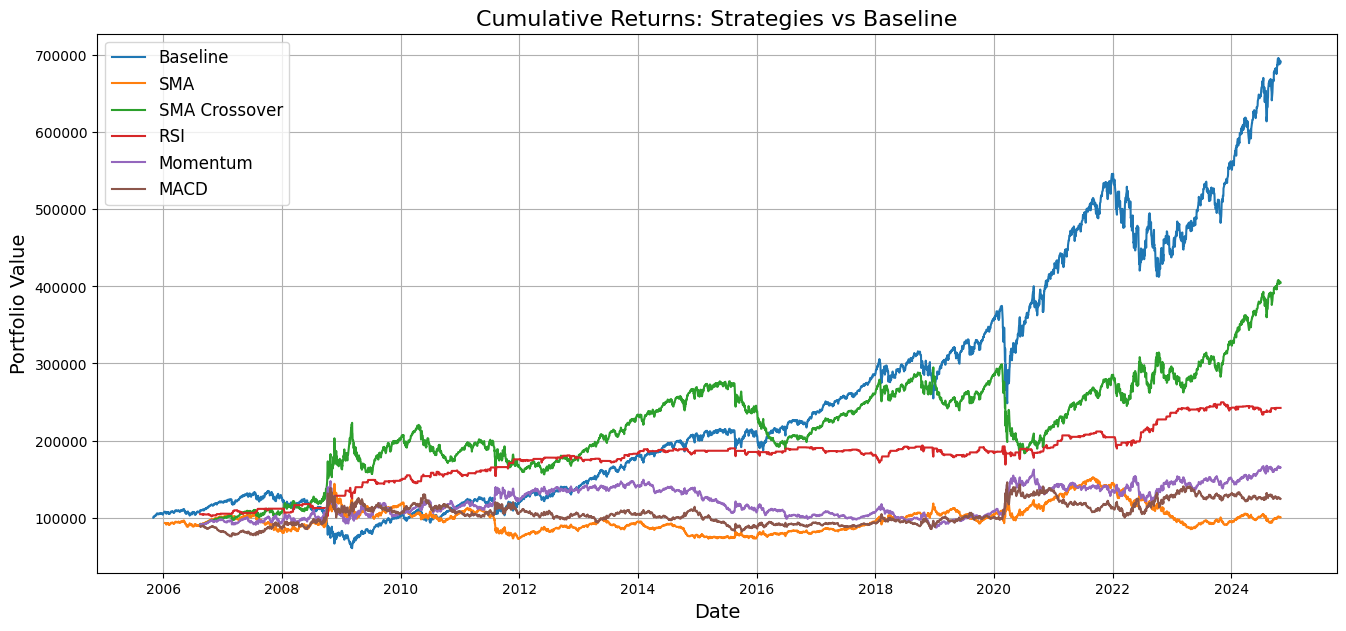

In [42]:
# Adding SMA to the list of strategies
strategies = {
    "Baseline": ("Baseline Portfolio Value", data_baseline),
    "SMA": ("SMA Portfolio Value", data_sma),
    "SMA Crossover": ("SMA Portfolio Value", data_sma_crossover),
    "RSI": ("RSI Portfolio Value", data_rsi),
    "Momentum": ("Momentum Portfolio Value", data_momentum),
    "MACD": ("MACD Portfolio Value", data_macd)
}

# Calculate performance metrics for all strategies
metrics = {}
for strategy_name, (portfolio_column, strategy_data) in strategies.items():
    metrics[strategy_name] = calculate_metrics(strategy_data, portfolio_column)

# Convert metrics into a DataFrame for easier visualization
metrics_df = pd.DataFrame(metrics).T
metrics_df.index.name = "Strategy"
metrics_df.columns = ["Sharpe Ratio", "CAGR", "Max Drawdown", "Final Portfolio Value"]

# Print the performance metrics
print(metrics_df)

# Bar chart to compare Sharpe Ratio, CAGR, and Max Drawdown
metrics_df[["Sharpe Ratio", "CAGR", "Max Drawdown"]].plot(kind="bar", figsize=(12, 6), title="Strategy Performance Metrics")
plt.ylabel("Value")
plt.grid(axis="y")
plt.show()

# Plot cumulative returns for all strategies
plt.figure(figsize=(16, 7))
for strategy_name, (portfolio_column, strategy_data) in strategies.items():
    plt.plot(strategy_data.index, strategy_data[portfolio_column], label=strategy_name)

plt.title("Cumulative Returns: Strategies vs Baseline", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Portfolio Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Part3 TOP 3 Strategies

Executive Summary of Top 3 Strategies:
Strategy: RSI
  Sharpe Ratio: 0.52
  CAGR: 4.73%
  Max Drawdown: -13.16%
  Final Portfolio Value: $242,378.27
--------------------------------------------------
Strategy: SMA Crossover
  Sharpe Ratio: 0.52
  CAGR: 8.52%
  Max Drawdown: -38.89%
  Final Portfolio Value: $404,775.12
--------------------------------------------------
Strategy: Momentum
  Sharpe Ratio: 0.26
  CAGR: 3.32%
  Max Drawdown: -42.09%
  Final Portfolio Value: $165,166.27
--------------------------------------------------


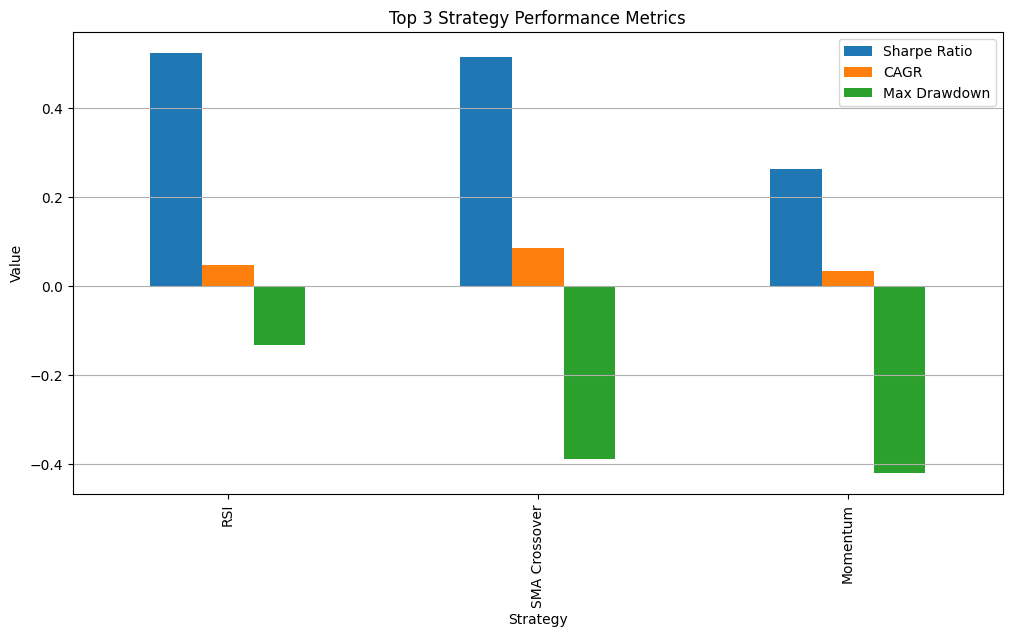

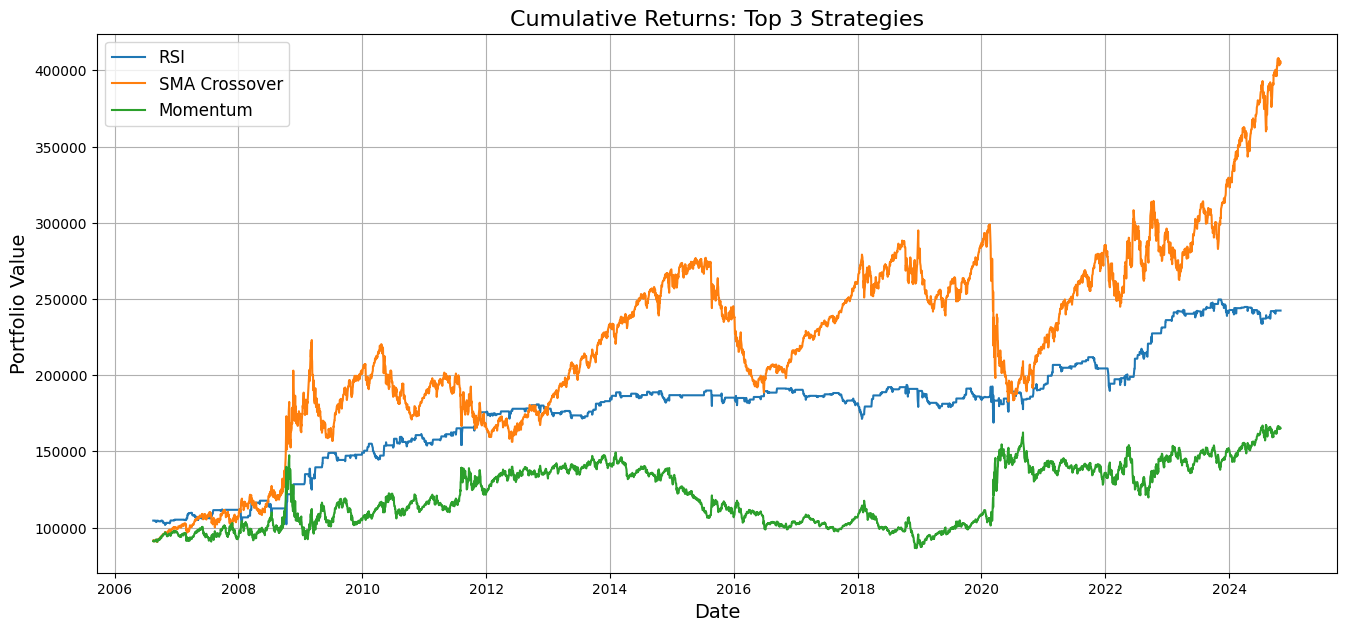

In [43]:
# 排除 Baseline 策略
metrics_without_baseline = metrics_df.drop("Baseline")

# 获取 Sharpe Ratio 最高的前三个策略
top_strategies = metrics_without_baseline.sort_values("Sharpe Ratio", ascending=False).head(3)

# 打印 Executive Summary
print("Executive Summary of Top 3 Strategies:")
for idx, row in top_strategies.iterrows():
    print(f"Strategy: {idx}")
    print(f"  Sharpe Ratio: {row['Sharpe Ratio']:.2f}")
    print(f"  CAGR: {row['CAGR']:.2%}")
    print(f"  Max Drawdown: {row['Max Drawdown']:.2%}")
    print(f"  Final Portfolio Value: ${row['Final Portfolio Value']:,.2f}")
    print("-" * 50)

# 绘制 Sharpe Ratio、CAGR 和 Max Drawdown 的柱状图
top_strategies[["Sharpe Ratio", "CAGR", "Max Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Top 3 Strategy Performance Metrics"
)
plt.ylabel("Value")
plt.grid(axis="y")
plt.show()

# 绘制累计收益曲线
plt.figure(figsize=(16, 7))
for strategy_name in top_strategies.index:
    portfolio_column, strategy_data = strategies[strategy_name]
    plt.plot(strategy_data.index, strategy_data[portfolio_column], label=strategy_name)

plt.title("Cumulative Returns: Top 3 Strategies", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Portfolio Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# Part4: Problems And Improvement
## BASELINE Strategy:
> The BASELINE strategy is straightforward to understand, focusing on capturing overall market returns by holding an index for the long term. It’s well-suited for investors who prefer a low-maintenance approach. However, it comes with notable drawbacks. During bear markets, the strategy often experiences significant losses, making it difficult to mitigate risk. It also overlooks the impact of market cycles on long-term returns.

> One of the main issues is that it assumes markets will rise over time, which neglects the importance of diversification. Relying solely on a single asset, such as an index, can lead to concentrated risk. Additionally, the strategy does not incorporate measures to manage risk, such as adjusting for market volatility or limiting drawdowns, nor does it offer any mechanism for dynamic rebalancing. As a result, it may not meet the needs of investors with varying risk tolerances.

> To fix these problems, the strategy could be improved by introducing risk management tools, such as volatility adjustments, and incorporating a wider range of assets, like bonds and gold, to achieve better diversification. These changes could make the strategy more resilient and better equipped to handle different market conditions.
## SMA Crossover Strategy:
> The SMA Crossover strategy tries to identify trend reversals by using the crossing signals between short-term and long-term moving averages. This makes it more suitable for markets where trends are clearly shifting. However, because moving averages inherently lag behind price movements, the signals often come too late, causing traders to miss the best opportunities. In sideways markets, frequent crossover signals can lead to overtrading, which in turn reduces returns. Fixed moving average windows are another limitation, as they don’t adjust to changing market conditions, making the strategy less effective when trends vary in strength.

> Another problem is the risk of forward-looking bias in backtesting, such as mishandling `shift(1)`, which can result in unreliable results. The strategy also overlooks transaction costs, like fees and slippage, which means backtest performance may be overstated. In practice, the SMA Crossover strategy often struggles to adapt to rapidly changing market environments, highlighting its lack of robustness.

> It’s worth considering dynamic adjustments to the moving average windows to better respond to market volatility. Adding complementary indicators, like Bollinger Bands or RSI, could help reduce false signals in sideways markets. Incorporating trading cost simulations would also provide a more accurate picture of the strategy’s real-world performance.
## RSI Strategy:
> The RSI strategy generates trading signals based on overbought (>70) and oversold (<30) levels, making it suitable for short-term volatile markets. However, it has several issues. In trending markets, the RSI often triggers false signals due to prolonged overbought or oversold conditions. Additionally, frequent trading in volatile markets leads to high transaction costs, which can significantly erode returns. The strategy typically relies on fixed thresholds and windows, lacking adaptability to changing market volatility. 

> Moreover, it does not account for transaction costs or slippage, and potential forward-looking bias (e.g., data leakage from future values) can render backtest results unreliable in practical applications. 

> The strategy could implement dynamic threshold adjustments, modifying overbought/oversold levels based on market volatility. Combining RSI with trend filtering—for instance, only buying during uptrends—can further reduce false signals. Simulating trading costs would provide a more realistic assessment of returns, and conducting sub-market testing would help evaluate stability across different market conditions. These improvements would make the RSI strategy more reliable and applicable in both theoretical and practical contexts.

## Statement:
> We(Tingjia LU, Yonghan Zhang) set out to design and implement various quantitative trading strategies, including baseline and momentum-based approaches. The goal was to backtest and evaluate their performance under different market conditions while presenting the results through clear and insightful visualizations. We were responsible for developing the Baseline Strategy, SMA, SMA Crossover, MACD, and RSI strategies. For each of these momentum strategies, we completed all aspects of the project, including data downloading and preprocessing, strategy design and signal generation, performance evaluation, and result visualization. Additionally, we also attempted a combination strategy using MACD and RSI, but the results were less effective than expected. In the final stage, we combined all the trading strategies and conducted a comprehensive comparative analysis of their performance. We successfully met all project requirements through effective teamwork and code integration.